In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import catboost
from catboost import CatBoostClassifier, Pool

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
# from sklearn.model_selection import  cross_val_score
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, chi2

import yfinance as yf
yf.pdr_override() 
from stockstats import StockDataFrame, wrap
import pandas_datareader.data as web
from pandas_datareader.famafrench import get_available_datasets, FamaFrenchReader
import pickleshare

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

import pypfopt as ppo
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import black_litterman, risk_models, plotting, objective_functions

In [3]:
# datasets = get_available_datasets()
# print('No. of datasets:{0}'.format(len(datasets)))
# datasets
# # 'F-F_Momentum_Factor_daily'
# # 'F-F_ST_Reversal_Factor_daily'
# # 'F-F_LT_Reversal_Factor_daily'
# # 'Developed_ex_US_3_Factors_Daily'

In [3]:
# Define the start and end dates
startDate = '2016-03-01'
endDate = '2022-01-01'

In [4]:
# FAMA FRENCH

# Define the factors you want to download
factors = 'F-F_Research_Data_5_Factors_2x3_daily'
factors_mom = 'F-F_Momentum_Factor_daily'
factors_st_rev = 'F-F_ST_Reversal_Factor_daily'
factors_lt_rev = 'F-F_LT_Reversal_Factor_daily'

# Create a FamaFrenchReader object with the factors and dates
ff_reader = FamaFrenchReader(symbols=factors, start=startDate, end=endDate)
ff_reader_mom = FamaFrenchReader(symbols=factors_mom, start=startDate, end=endDate)
ff_reader_st_rev = FamaFrenchReader(symbols=factors_st_rev, start=startDate, end=endDate)
ff_reader_lt_rev = FamaFrenchReader(symbols=factors_lt_rev, start=startDate, end=endDate)
# Load the data into a Pandas DataFrame

X_ff_l0 = pd.DataFrame(ff_reader.read()[0])
X_ff_l1 = pd.DataFrame(ff_reader.read()[0]).shift(1)
X_ff_l2 = pd.DataFrame(ff_reader.read()[0]).shift(2)
X_ff_l3 = pd.DataFrame(ff_reader.read()[0]).shift(3)
X_ff_l4 = pd.DataFrame(ff_reader.read()[0]).shift(4)
X_ff_l5 = pd.DataFrame(ff_reader.read()[0]).shift(5)
X_ff_l6 = pd.DataFrame(ff_reader.read()[0]).shift(6)
X_ff_l7 = pd.DataFrame(ff_reader.read()[0]).shift(7)
X_ff_l8 = pd.DataFrame(ff_reader.read()[0]).shift(8)
X_ff_l9 = pd.DataFrame(ff_reader.read()[0]).shift(9)
X_ff_l10 = pd.DataFrame(ff_reader.read()[0]).shift(10)
X_ff_mom = pd.DataFrame(ff_reader_mom.read()[0])
X_ff_st_rev = pd.DataFrame(ff_reader_st_rev.read()[0])
X_ff_lt_rev = pd.DataFrame(ff_reader_lt_rev.read()[0])

X_ff_l = pd.concat([X_ff_l0,
                    X_ff_l1,
                    X_ff_l2,
                    X_ff_l3,
                    X_ff_l4,
                    X_ff_l5,
                    X_ff_l6,
                    X_ff_l7, 
                    X_ff_l8,
                    X_ff_l9,
                    X_ff_l10,
                    X_ff_mom,
                    X_ff_st_rev,
                    X_ff_lt_rev 
                   ], axis = 1)

X_ff_l.columns = ["Mkt-RF_0", "SMB_0", "HML_0", "RMW_0", "CMA_0", "RF_0",
                  "Mkt-RF_1", "SMB_1", "HML_1", "RMW_1", "CMA_1", "RF_1",
                  "Mkt-RF_2", "SMB_2", "HML_2", "RMW_2", "CMA_2", "RF_2",
                  "Mkt-RF_3", "SMB_3", "HML_3", "RMW_3", "CMA_3", "RF_3",
                  "Mkt-RF_4", "SMB_4", "HML_4", "RMW_4", "CMA_4", "RF_4",
                  "Mkt-RF_5", "SMB_5", "HML_5", "RMW_5", "CMA_5", "RF_5",
                  "Mkt-RF_6", "SMB_6", "HML_6", "RMW_6", "CMA_6", "RF_6",
                  "Mkt-RF_7", "SMB_7", "HML_7", "RMW_7", "CMA_7", "RF_7",
                  "Mkt-RF_8", "SMB_8", "HML_8", "RMW_8", "CMA_8", "RF_8",
                  "Mkt-RF_9", "SMB_9", "HML_9", "RMW_9", "CMA_9", "RF_9",
                  "Mkt-RF_10", "SMB_10", "HML_10", "RMW_10", "CMA_10", "RF_10",
                  "Mom", "ST_REV", "LT_REV"]

In [5]:
def z_normalize(data):
   
    # Вычисляем среднее значение и стандартное отклонение для каждой фичи
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    
    # Выполняем Z-нормализацию
    normalized_data = (data - mean) / std
    
    return normalized_data

In [7]:
# df_rf = yf.download('^TYX', startDate, endDate, progress=False )
# df_rf = pd.DataFrame(data=df)
# df_rf
# rf = df_rf["Adj Close"]/365
# rf

In [6]:
def data_download(ticker,startDate, endDate):
    
    df = yf.download(ticker, startDate, endDate, progress=False )
    df = pd.DataFrame(data=df)
#     df = df.drop(['Adj Close'], axis = 1)

    raw_df = df
    raw_df = wrap(raw_df)
    raw_df.init_all()
    
    y_l6 = raw_df.loc[:, 'log-ret'].shift(5)
    y_l5 = raw_df.loc[:, 'log-ret'].shift(4)
    y_l4 = raw_df.loc[:, 'log-ret'].shift(3)    
    y_l3 = raw_df.loc[:, 'log-ret'].shift(2)
    y_l2 = raw_df.loc[:, 'log-ret'].shift(1)
    y_l1 = raw_df.loc[:, 'log-ret'].shift(-11)

    X_ind = raw_df.drop(['log-ret','rate','change'], axis=1)
    dta = pd.concat([X_ind, X_ff_l,y_l6,y_l5,y_l4,y_l3,y_l2, y_l1], axis = 1)


    dta.dropna(inplace = True)

    return(dta)

In [309]:
# # Get bin intervals
# bin_intervals = kb.bin_edges_

# print('Bin intervals:')
# print(bin_intervals)

In [97]:
# plt.hist(y_binned, bins=2, edgecolor='black')
# plt.xlabel('Bin')
# plt.ylabel('Frequency')
# plt.title('Histogram of Binned Data')
# plt.show()

In [70]:
# bin_counts = pd.Series(y_binned.reshape(-1)).value_counts().sort_index()

# print('Bin counts:')
# print(bin_counts)

In [7]:
AAPL = data_download('AAPL',startDate, endDate)
y = AAPL.iloc[:, -1:]
X_add_ff = AAPL.iloc[:,0:-1]

100%|█████████████████████████████████████████████| 8/8 [02:50<00:00, 21.30s/it]


MIN Accuracy Score:  0.521
**************************
MEAN Accuracy Score:  0.541
**************************
MAX Accuracy Score:  0.612


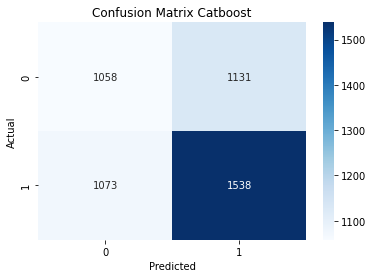

In [228]:
# Define the sliding window parameters
train_window = 1200
test_window = 30


prices_total = pd.DataFrame()
pred_total = pd.DataFrame()
y_train_total = pd.DataFrame()
y_test_total = pd.DataFrame()
ret_total = pd.DataFrame()
ret_test_total = pd.DataFrame()
pred_proba_total = pd.DataFrame()

input_cols = X_add_ff.columns
market_prices = data_download('^GSPC', startDate, endDate)['close']



# tickers =['NEE', 'ORCL', 'LIN', 'COST', 'PG', 'CVX', 'ADBE', 'LLY', 'NOW', 'ADP',
#        'AMAT', 'SPGI', 'ABBV', 'TMO', 'INTU', 'LOW', 'GOOGL', 'ACN', 'GOOG', 'HD'] #для сеточки

tickers = ['MO', 'TMO', 'CMCSA', 'WFC', 'ACN', 'AMGN', 'GE', 'ADP', 'NEE', 'QCOM',
       'MS', 'ADBE', 'AAPL', 'HD', 'SBUX', 'INTU', 'ORCL', 'LMT', 'WBA','GOOG']


# tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'JPM', 'JNJ', 'V',
#            'WMT', 'PG', 'BAC', 'UNH', 'NVDA', 'MA', 'HD', 'DIS', 'VZ', 'CRM', 'PYPL',
#            'KO', 'ADBE', 'INTC', 'NFLX', 'PFE', 'ABT', 'T', 'BMY', 'MRK', 'ACN', 'XOM',
#            'CSCO', 'CVX', 'BA', 'CMCSA', 'WFC', 'PEP', 'GOOG', 'ORCL', 'COST', 'MCD', 
#            'ABBV', 'MDT', 'NKE', 'AMGN', 'TXN', 'NEE', 'MMM', 'HON', 'SBUX', 'NVS',
#            'LMT', 'RTX', 'UNP', 'TMUS', 'DHR', 'UPS', 'IBM', 'BABA', 'QCOM', 'AMT', 
#            'TMO', 'AVGO', 'CVS', 'LIN', 'DE', 'AXP', 'CAT', 'LRCX', 'WBA', 
#            'GE', 'SO', 'LOW', 'D', 'MO', 'C', 'SPGI', 'COP', 'BLK', 'NOW', 
#            'CME', 'GS', 'INTU', 'FDX', 'VRTX','CI', 'ADP', 'TGT',
#            'AMAT', 'DUK', 'TJX', 'GM', 'MS', 'SCHW']


# Loop over the sliding windows

for i in tqdm(range(0, len(y) - train_window - test_window + 1, test_window)):
    
    pred_class_in_window = pd.DataFrame()    
    y_train_in_window = pd.DataFrame()
    y_test_in_window = pd.DataFrame()
    ret_in_window = pd.DataFrame()
    prices_in_window = pd.DataFrame()
    ret_test_in_window = pd.DataFrame()
    pred_proba = pd.DataFrame()

#     ret_for_mrtz_total = pd.DataFrame()
    
    for ticker in tickers:
        
        #data download and preprocessing
        current_dataset = data_download(ticker,startDate, endDate)
        y = current_dataset.iloc[:, -1:]
        X = z_normalize(current_dataset.iloc[:,0:-1])
        
#         kb = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy= "quantile")
#         kb.fit(y.values.reshape(-1,1))
#         y_binned = kb.transform(y.values.reshape(-1,1))
#         y_binned = pd.DataFrame(y_binned)

        #разбиваю доходности на два класса
        y_binned = []
        #y = np.array(y).reshape(-1,1)

        for val in y.values:
            if val > 0:
                y_binned.append([1])
            elif val <= 0:
                y_binned.append([0])
        
        
        # Extract the training and testing samples
        y_train_sample = pd.DataFrame(y_binned[i:i+train_window])
        X_train_sample = X.iloc[i:i+train_window, :]

        y_test_sample = pd.DataFrame(y_binned[i+train_window:i+train_window+test_window])
        X_test_sample = X.iloc[i+train_window:i+train_window+test_window]

        # Perform feature selection
        k = 20  # Number of top features to select
        selector = SelectKBest(score_func=f_classif, k=k)  
        X_train_selected = selector.fit_transform(X_train_sample, y_train_sample)
        X_test_selected = selector.transform(X_test_sample)

        #Pooling
        train_dataset = catboost.Pool(X_train_selected, y_train_sample) 
        test_dataset = catboost.Pool(X_test_selected, y_test_sample)

        # Train the CatBoost classifier
        model = CatBoostClassifier(iterations=10,
                                   learning_rate=1,
                                   loss_function = 'CrossEntropy',
                                   l2_leaf_reg=15,
                                  random_seed = 42)
        
        model.fit(train_dataset, verbose = 0)

        # Evaluate the model
        pred_class = model.predict_proba(test_dataset)
        
        pred_class = pd.DataFrame(pred_class).iloc[:,1]
        pred_class_in_window[ticker] = pd.DataFrame(model.predict(test_dataset))
        y_train_in_window[ticker] = y.iloc[i:i+train_window]
        y_test_in_window[ticker] = y_test_sample
        ret_test_in_window[ticker] = y.iloc[i+train_window:i+train_window+test_window].reset_index(drop = True)
        
        #predictions to views
        y_0 = []
        y_1 = []
        yy = np.array(pd.concat([pd.DataFrame(y.iloc[i:i+train_window].values), y_train_sample], axis = 1))
        
        for k in range(len(y_train_sample)):
            if yy[k,1] == 1:
                y_1.append(yy[k,0])
            else:
                y_0.append(yy[k,0])
        

        pred_ret = []
        for j in range(len(pred_class)):
            if pred_class[j] > 0.5:
                pred_ret.append(np.mean(y_1[-40:]))
            else: 
                pred_ret.append(np.mean(y_0[-40:]))    
        ret_in_window[ticker]= pred_ret      
        pred_proba[ticker] = pred_class
#     #aggregate inf from loop
    pred_total = pd.concat([pred_total,pred_class_in_window], axis = 0) 
    ret_total = pd.concat([ret_total,ret_in_window], axis = 0)
    y_train_total = pd.concat([y_train_total,pd.DataFrame(y_train_in_window.mean()).T], axis = 0) 
    y_test_total = pd.concat([y_test_total,y_test_in_window.reset_index(drop = True)], axis = 0) 
    
    ret_test_total = pd.concat([ret_test_total, ret_test_in_window], axis = 0)
    pred_proba_total = pd.concat([pred_proba_total, pred_proba], axis = 0)

acc = []
for i in range(len(tickers)):
    
    acc.append(accuracy_score(y_test_total.iloc[:,i], pred_total.iloc[:,i]))

    
print("MIN Accuracy Score: ", round(np.min(acc),3))
print("**************************")
print("MEAN Accuracy Score: ", round(np.mean(acc),3))
print("**************************")
print("MAX Accuracy Score: ", round(np.max(acc),3))
# ret_test_total = ret_test_total.T
dataaa = {0:acc}
acc_df = pd.DataFrame.from_dict(dataaa, orient='index', columns = tickers)
# acc_df

# Create confusion matrix
y_true = np.array(y_test_total).flatten()
y_pred = np.array(pred_total).flatten()

cm = confusion_matrix(y_true, y_pred)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and axis ticks
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Catboost')

# Show the plot
plt.savefig('confusion_matrix_catboost.jpeg', dpi=300)
plt.show()

In [301]:
from scipy import stats

# Задаем выборку из наблюдений
data = acc

# Вычисляем среднее значение и стандартное отклонение выборки
mean = np.mean(data)
std_dev = np.std(data, ddof=1)  # ddof=1 означает, что стандартное отклонение вычисляется по выборке (n-1)

# Задаем уровень доверия
confidence_level = 0.99

# Вычисляем количество степеней свободы
degrees_of_freedom = len(data) - 1

# Вычисляем критическое значение t-статистики
t_critical = stats.t.ppf((1 + confidence_level) / 2, df=degrees_of_freedom)

# Вычисляем стандартную ошибку
standard_error = std_dev / np.sqrt(len(data))

# Вычисляем доверительный интервал
lower_bound = mean - t_critical * standard_error
upper_bound = mean + t_critical * standard_error

# Выводим результат
print(f"Доверительный интервал с уровнем доверия {confidence_level}: ({round(lower_bound, 3)},{round(upper_bound,3)})")

Доверительный интервал с уровнем доверия 0.99: (0.527,0.554)


In [303]:
acc_cat = pd.DataFrame(acc)
acc_cat.to_csv('acc_cat.csv', encoding='utf-8')

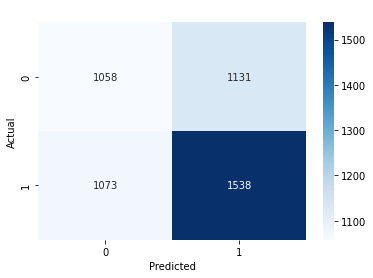

In [273]:
# Create confusion matrix
y_true = np.array(y_test_total).flatten()
y_pred = np.array(pred_total).flatten()

cm = confusion_matrix(y_true, y_pred)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and axis ticks
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(' ')

# Show the plot
plt.savefig('confusion_matrix_catboost.jpeg', dpi=300)
plt.show()

In [40]:
# ret_test_total.to_csv('test.csv', encoding='utf-8')
# ret_total.to_csv('cat.csv', encoding='utf-8')

In [259]:
corr_matrix = []
for t in tickers: 
    b =ret_test_total[t].values
    # b =y_test_total.values.flatten()
    a = pred_total[t].values
    ab = pd.concat([pd.DataFrame(a),pd.DataFrame(b)], axis = 1)
    c = ab.corr()
    corr_matrix.append(c.iloc[0,1])
# corr_matrix.columns = tickers  
print(corr_matrix)

[0.08512523858707746, -0.03812850587357064, 0.08993064041124402, -0.022088323112504162, 0.06266841291750118, 0.08327992683269085, 0.08187326101824995, -0.02846107970087132, 0.09424256094716486, 0.006107788823551157, 0.0876692807185672, 0.08213139438949134, 0.027991620680910646, 0.06366259335268237, 0.12467145907969404, -0.02144462631474762, 0.04660376590954299, -0.01321210936566571, 0.0598851119551475, 0.11264707986541918]


In [229]:
b =ret_test_total.values.flatten()
# b =y_test_total.values.flatten()
a = pred_total.values.flatten()

ab = pd.concat([pd.DataFrame(a),pd.DataFrame(b)], axis = 1)
ab.corr()

,0,0
0,1.000000,0.048199
0,0.048199,1.000000


In [230]:
top_20 = acc_df.T.sort_values(by = 0).tail(20)
print(top_20.T.columns)
print(top_20.T)

Index(['MO', 'TMO', 'CMCSA', 'WFC', 'ACN', 'AMGN', 'GE', 'ADP', 'NEE', 'ADBE',
       'QCOM', 'MS', 'AAPL', 'HD', 'SBUX', 'INTU', 'ORCL', 'LMT', 'WBA',
       'GOOG'],
      dtype='object')
         MO       TMO     CMCSA    WFC    ACN   AMGN        GE       ADP  \
0  0.520833  0.520833  0.520833  0.525  0.525  0.525  0.529167  0.529167   

        NEE    ADBE    QCOM      MS      AAPL        HD  SBUX  INTU      ORCL  \
0  0.533333  0.5375  0.5375  0.5375  0.541667  0.545833  0.55  0.55  0.554167   

        LMT     WBA    GOOG  
0  0.558333  0.5625  0.6125  


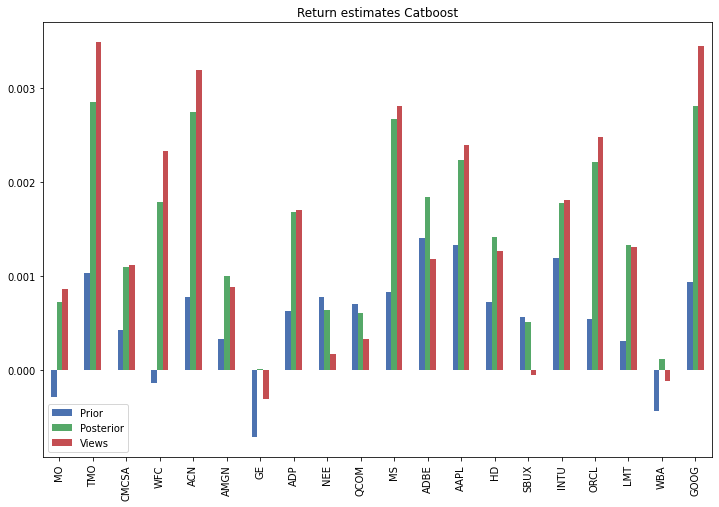

In [293]:
prices = pd.DataFrame() 
w_bl_total = pd.DataFrame()
w_m_total = pd.DataFrame()
market_prior_total = pd.DataFrame() 
y_train_total_all = pd.DataFrame()
ret_bl_total = pd.DataFrame()
view_total = pd.DataFrame()

confidences = []
for c in range(len(tickers)):
    confidences.append(0.8)


#prices for cov matrix
for ticker in tickers:
    current_dataset = data_download(ticker,startDate, endDate)
    prices[ticker] = current_dataset['close']
    
#creating market prior total list
for i in range(len(y_train_total)):
    for j in range(test_window):
        y_train_total_all = pd.concat([y_train_total_all,
                                       pd.DataFrame(y_train_total.iloc[i,:]).T], axis = 0)

        
cov_window = 252
# y_train_total_all = y_train_total_all    

#Black-Litterman part
ret_total=ret_total.reset_index(drop=True)    

delta_window = 756

for k in range(len(ret_total)):
    
    market_prior = y_train_total_all.iloc[k, :].values
    market_prior_total = pd.concat([market_prior_total,
                                    pd.DataFrame(market_prior, index = tickers).T], axis = 0)
    
    prices_in_window = prices.iloc[k + train_window - cov_window:k+train_window, :]
    
    
#     S = np.sqrt(prices_in_window.cov())
    S = risk_models.CovarianceShrinkage(prices_in_window,returns_data=False,
                                        frequency=1, log_returns=False).ledoit_wolf()
    
    delta = black_litterman.market_implied_risk_aversion(market_prices[k+train_window-delta_window:k+train_window])
#     delta = 100
    
    #creating views for BL model
    viewdict = {}
    for t in tickers:
        viewdict[t] = ret_total.loc[k,t] 
    view_df = pd.DataFrame(viewdict, index = [0])
    view_total = pd.concat([view_total,view_df], axis = 0)

    bl = BlackLittermanModel(cov_matrix = S,
                             pi = market_prior,
                             absolute_views=viewdict,
                             omega="idzorek",
#                              risk_aversion = delta,
                             view_confidences=confidences,
                             tau = 1)

    #Posterior estimate of returns
    ret_bl = bl.bl_returns()
    ret_bl_total = pd.concat([ret_bl_total, pd.DataFrame(ret_bl).T], axis = 0)
    

    S_bl = bl.bl_cov()                                 
    ef = EfficientFrontier(ret_bl, S_bl)
    ef.add_objective(objective_functions.L2_reg, gamma = 0.001)
#     bl.optimize().add_constraint(lambda x : x >= -1)
#     ef.add_constraint(lambda x : x >= -1)
#     ef.add_constraint(lambda x : x <= 1)
    ef.efficient_risk(target_volatility = 0.019, market_neutral=False)
#     ef.min_volatility()
    
    weights = ef.clean_weights()
#     weights = bl.clean_weights()
#     weights = bl.bl_weights()
    w_bl = pd.DataFrame(weights, index = [0])
    w_bl_total = pd.concat([w_bl_total, w_bl], axis = 0)
    
    
    #Market
    ef_m = EfficientFrontier(market_prior, S)
    ef_m.add_objective(objective_functions.L2_reg, gamma = 0.1)
#     ef_m.add_constraint(lambda x : x >= -1)
#     ef_m.add_constraint(lambda x : x <= 1)
    ef_m.efficient_risk(target_volatility = 0.019, market_neutral=False)
#     ef_m.min_volatility()
    
    weights_m = ef_m.clean_weights()
    w_m = pd.DataFrame(weights_m, index = [0])
    w_m_total = pd.concat([w_m_total, w_m], axis = 0)
    
    #table for compare estimaded returns 
#     rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
#                                index=["Prior", "Posterior", "Views"]).T
    
rets_df_total = pd.DataFrame([market_prior_total.mean(), ret_bl_total.mean(), view_total.mean()],
                               index=["Prior", "Posterior", "Views"]).T


# print(rets_df_total)
rets_df_total.plot.bar(figsize=(12,8))
plt.title('Return estimates Catboost')
# Show the plot
plt.savefig('Return estimates Catboost.jpeg', dpi=300)

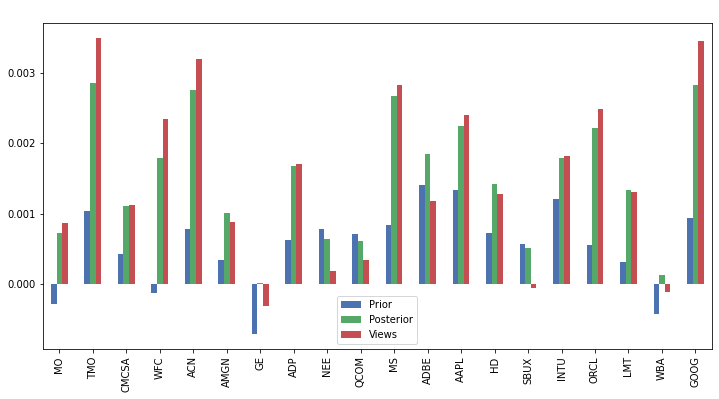

In [279]:
# print(rets_df_total)
rets_df_total.plot.bar(figsize=(12,6))
plt.title(' ')
# Show the plot
plt.savefig('Return estimates Catboost.jpeg', dpi=300)

In [280]:
bl_portf_rets = []
mrkt_portf_rets = []
naive_portf_rets = []

#naive

w_naive = []
for t in tickers:
    w_naive.append(1/len(tickers))
w_naive = pd.DataFrame(w_naive).T

w_naive_total = pd.DataFrame()
for i in range(len(w_bl_total)):
    w_naive_total = pd.concat([w_naive_total,w_naive], axis = 0)
w_naive_total.columns = tickers

for i in range(len(ret_test_total.iloc[:,0])):
    
    bl_portf_rets.append(ret_test_total.iloc[i,:].T.dot(w_bl_total.iloc[i,:]))
    mrkt_portf_rets.append(ret_test_total.iloc[i,:].T.dot(w_m_total.iloc[i,:]))
    naive_portf_rets.append(ret_test_total.iloc[i,:].T.dot(w_naive_total.iloc[i,:]))
    
std_bl = np.std(bl_portf_rets)
std_m = np.std(mrkt_portf_rets)
std_n = np.std(naive_portf_rets)
    
itog = pd.DataFrame(
    {'BL': [round(sum(bl_portf_rets),4),round(std_bl,4), round(sum(bl_portf_rets)/std_bl,4)],
     'MRKT': [round(sum(mrkt_portf_rets),4), round(std_m, 4), round(sum(mrkt_portf_rets)/std_m,4)],
     'NAIVE': [round(sum(naive_portf_rets),4), round(std_n, 4), round(sum(naive_portf_rets)/std_n,4)]}, 
    index = ['C_ret: ','Std: ',  'SR: '])
print(itog)

              BL     MRKT    NAIVE
C_ret:    0.3649   0.3057   0.2692
Std:      0.0084   0.0153   0.0082
SR:      43.1908  20.0280  32.7437


In [281]:
df_rebalancing_bl = pd.DataFrame(np.nan, index=w_bl_total.index, columns=w_bl_total.columns)
for i in range(1, len(w_bl_total)):
    df_rebalancing_bl.iloc[i] = w_bl_total.iloc[i] - w_bl_total.iloc[i-1]

# print the result
rebalancing_bl = abs(df_rebalancing_bl).sum().sum()

df_rebalancing_m = pd.DataFrame(np.nan, index=w_m_total.index, columns=w_m_total.columns)
for i in range(1, len(w_bl_total)):
    df_rebalancing_m.iloc[i] = w_m_total.iloc[i] - w_m_total.iloc[i-1]

# print the result
rebalancing_m = abs(df_rebalancing_m).sum().sum()


rebalancing_bl, rebalancing_m

(150.05310999999998, 5.089060000000002)

In [282]:
# pip install git+https://github.com/quantopian/pyfolio
import pandas as pd
import pyfolio as pf
import matplotlib.pyplot as plt
%matplotlib inline

In [246]:
ind = y.index[train_window:train_window + test_window*((len(y) - train_window)//test_window)].values

In [283]:
bl_returns = pd.Series(bl_portf_rets, index = ind)
m_returns = pd.Series(mrkt_portf_rets, index = ind)
# n_returns = pd.Series(naive_portf_rets, index = ind)
bl_returns.index = bl_returns.index.tz_localize('utc')
m_returns.index = m_returns.index.tz_localize('utc')
# n_returns.index = n_returns.index.tz_localize('utc')

Start date,2020-12-17
End date,2021-11-30
Total months,11
,Backtest
Annual return,33.794%
Cumulative returns,31.952%
Annual volatility,24.284%
Sharpe ratio,1.32
Calmar ratio,2.05
Stability,0.82
Max drawdown,-16.514%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,16.51,2021-08-19,2021-09-17,2021-10-20,45
1,11.59,2021-11-04,2021-11-29,NaT,NaN
2,9.02,2021-03-30,2021-04-27,2021-05-26,42
3,6.50,2021-01-28,2021-02-17,2021-03-17,35
4,4.65,2021-10-20,2021-10-27,2021-11-04,12


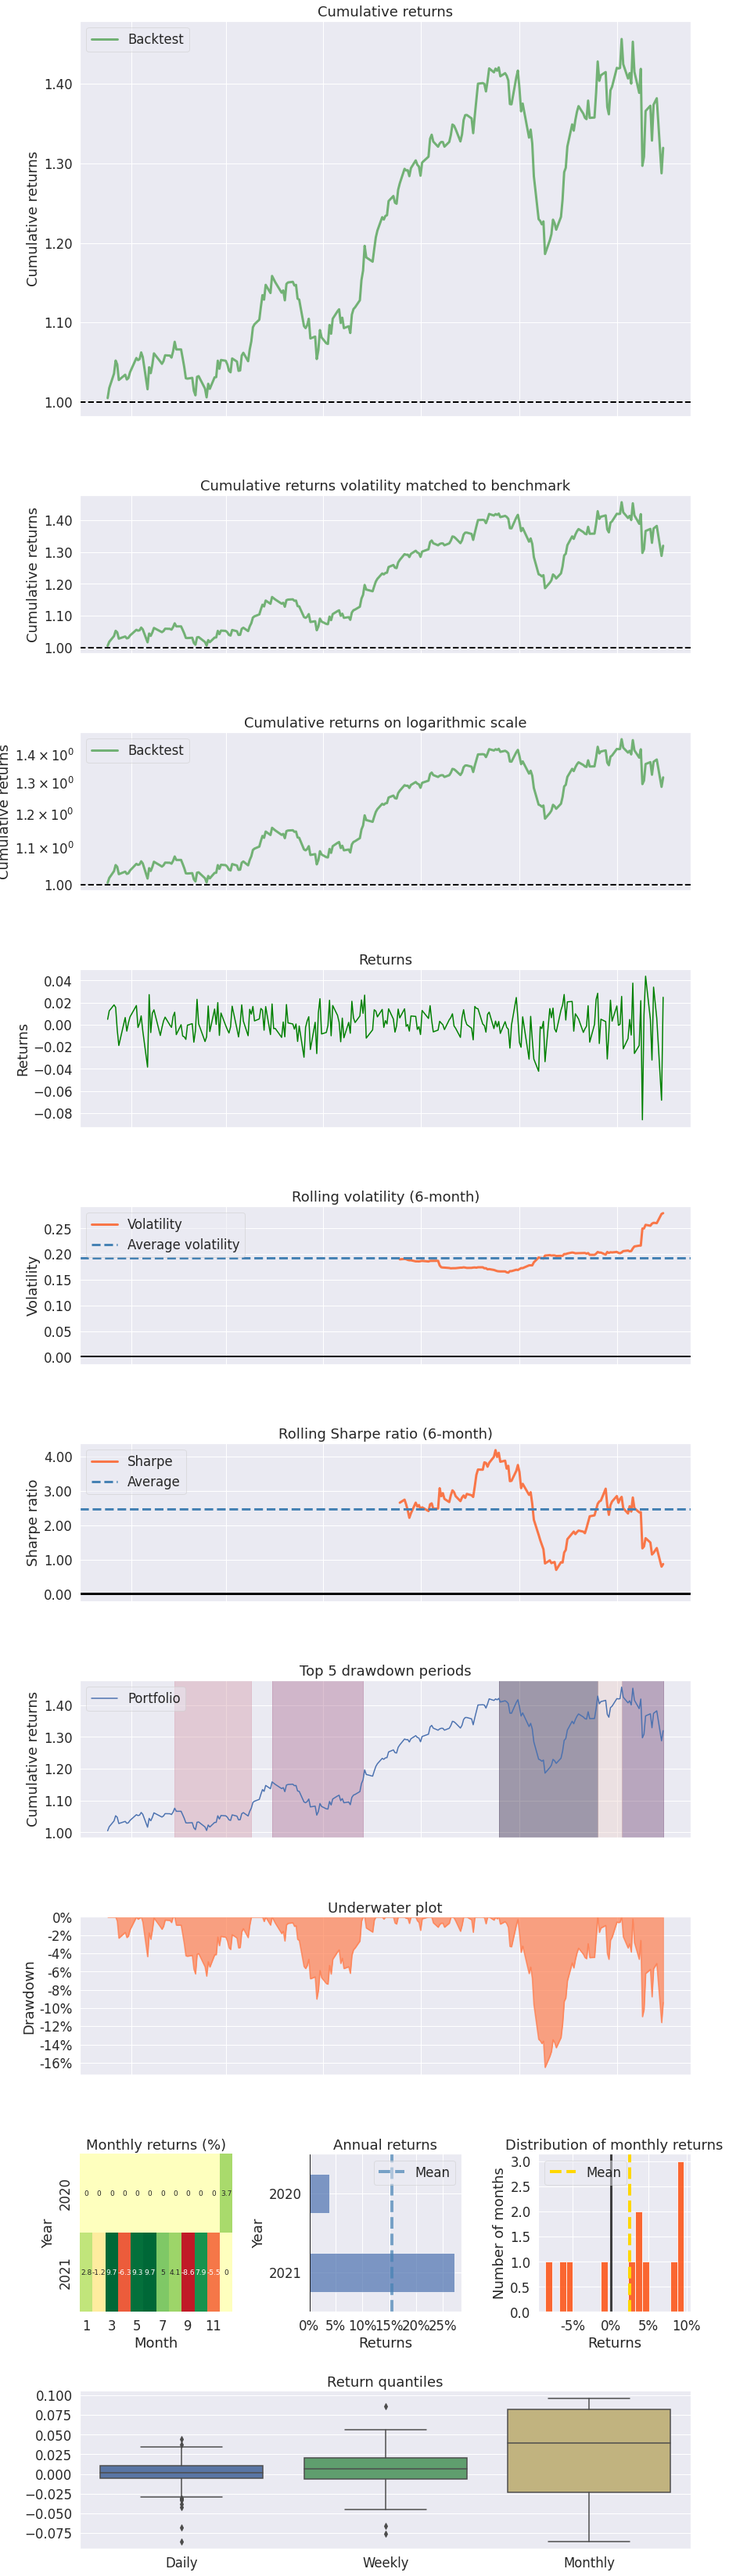

In [284]:
matplotlib.use('Agg')

f = pf.create_returns_tear_sheet(m_returns, return_fig=True)

# f.savefig('pyfolio_returns_catboost.jpeg', dpi=300)

Start date,2020-12-17
End date,2021-11-30
Total months,11
,Backtest
Annual return,45.34%
Cumulative returns,42.775%
Annual volatility,13.441%
Sharpe ratio,2.85
Calmar ratio,8.68
Stability,0.95
Max drawdown,-5.225%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,5.22,2021-08-19,2021-09-15,2021-10-04,33
1,4.25,2021-04-22,2021-04-27,2021-05-25,24
2,4.14,2021-11-03,2021-11-15,2021-11-24,16
3,3.98,2021-01-28,2021-02-10,2021-02-23,19
4,3.65,2021-05-27,2021-06-03,2021-06-16,15


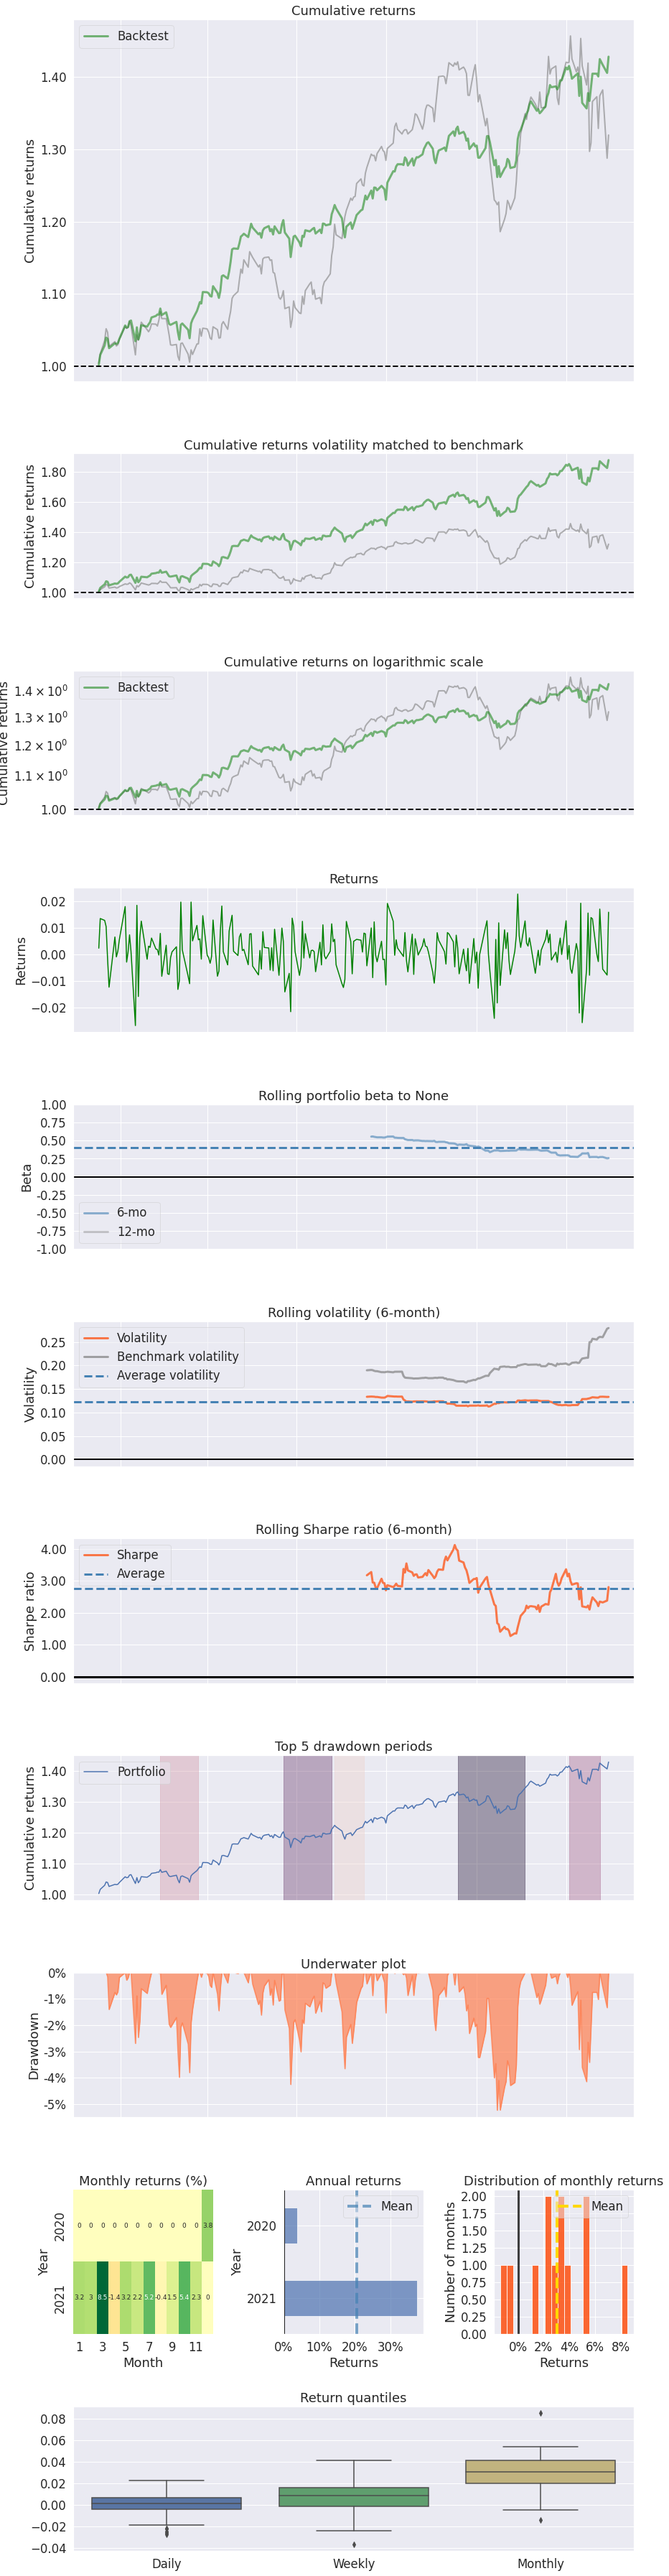

In [285]:
import matplotlib
matplotlib.use('Agg')

f = pf.create_returns_tear_sheet(bl_returns, benchmark_rets=m_returns, return_fig=True)

# f.savefig('pyfolio_returns_catboost.jpeg', dpi=300)

In [32]:
# pf.plotting.plot_returns(bl_returns)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix Catboost')

In [26]:
# pf.tears.create_simple_tear_sheet(bl_returns, benchmark_rets=m_returns)


# pf.plotting.plot_monthly_returns_dist(bl_returns)
# pf.plotting.plot_monthly_returns_heatmap(bl_returns)

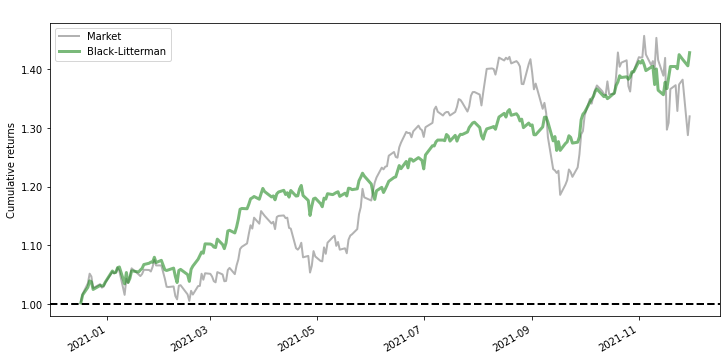

In [286]:
fig, ax = plt.subplots(figsize=(12,6))
pf.plotting.plot_rolling_returns(bl_returns,m_returns, ax=ax, legend_loc='best')
ax.legend(['Market', 'Black-Litterman'])
plt.title(' ')
plt.savefig('Cumulative_Returns_catboost.jpeg', dpi=300)

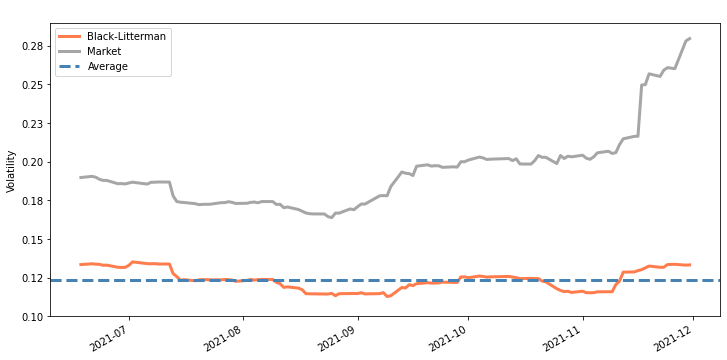

In [290]:
# pf.plotting.plot_rolling_returns(bl_returns, m_returns)
fig, ax = plt.subplots(figsize=(12,6))
pf.plotting.plot_rolling_volatility(bl_returns, m_returns, rolling_window=126)
ax.legend(['Black-Litterman', 'Market', 'Average'])
plt.title(' ')
ax.set_ylim([0.1, 0.29])
plt.savefig('rolling_volatility_catboost.jpeg', dpi=300)

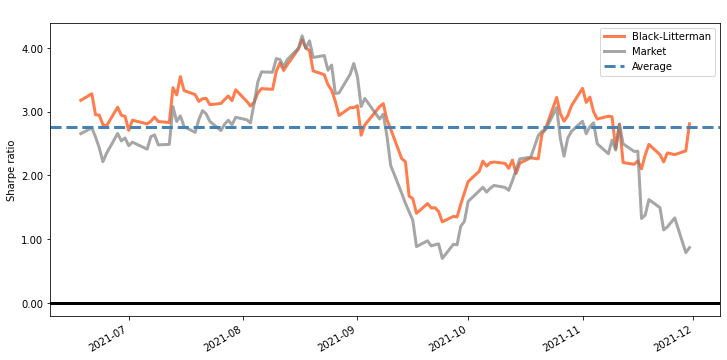

In [291]:
fig, ax = plt.subplots(figsize=(12,6))
pf.plotting.plot_rolling_sharpe(bl_returns,m_returns, figsize=(12,6))
ax.legend(['Black-Litterman', 'Market', 'Average'])
plt.title(' ')
plt.savefig('Rolling Sharpe ratio (6-month) catboost.jpeg', dpi=300)

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,6.01,2021-08-18,2021-09-17,2021-10-08,38
1,4.64,2021-01-28,2021-02-17,2021-02-24,20
2,3.95,2021-03-31,2021-04-27,2021-05-25,40
3,3.38,2021-11-09,2021-11-15,2021-11-19,9
4,2.89,2021-01-07,2021-01-13,2021-01-22,12


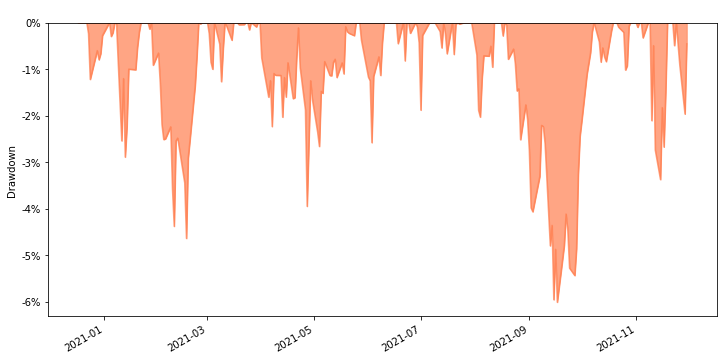

In [269]:
pf.plotting.show_worst_drawdown_periods(m_returns, top=5)
fig, ax = plt.subplots(figsize=(12,6))
pf.plotting.plot_drawdown_underwater(m_returns, figsize=(12,6))
plt.title(' ')
plt.savefig('Underwater Market portfolio catboost.jpeg', dpi=300)

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,5.22,2021-08-19,2021-09-15,2021-10-04,33
1,4.25,2021-04-22,2021-04-27,2021-05-25,24
2,4.14,2021-11-03,2021-11-15,2021-11-24,16
3,3.98,2021-01-28,2021-02-10,2021-02-23,19
4,3.65,2021-05-27,2021-06-03,2021-06-16,15


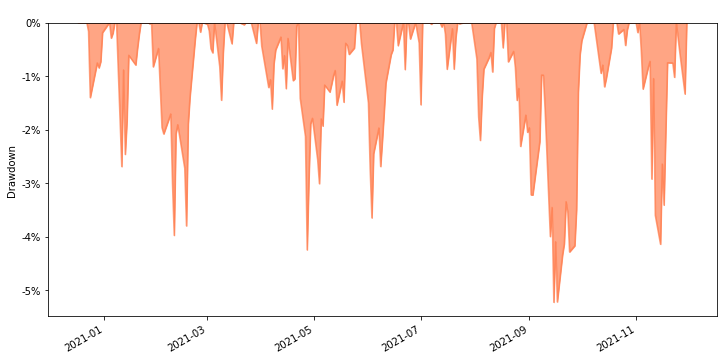

In [292]:
pf.plotting.show_worst_drawdown_periods(bl_returns, top=5)
fig, ax = plt.subplots(figsize=(12,6))
pf.plotting.plot_drawdown_underwater(bl_returns, figsize=(12,6))
plt.title(' ')
plt.savefig('Underwater Black-littarman portfolio catboost.jpeg', dpi=300)

In [58]:
# fig = pf.create_returns_tear_sheet(bl_returns, benchmark_rets=m_returns, return_fig=True)
# #  Store plots in a fil
# file_name = f"{CatBoost}_tearsheet.jpeg" 

# fig.savefig(catboost_backtest, format="jpeg")

In [57]:
# pf.create_bayesian_tear_sheet(bl_returns, live_start_date='2021-06-01')

In [ ]:
# stds = pd.DataFrame()
# y_for_std = pd.DataFrame()

# for ticker in tickers:

#     current_dataset = data_download(ticker,startDate, endDate)
#     y_for_std[ticker] = current_dataset.iloc[:, -1:]
#     stds[ticker] = np.std(current_dataset.iloc[:, -1:])

# std_bl = []
# for i in range(len(ret_test_total.iloc[:,0])):
#     std_bl.append(np.sqrt(w_bl_total.iloc[i,:].dot(y_for_std.cov()).dot(w_bl_total.iloc[i,:])))

# std_m = []
# for i in range(len(ret_test_total.iloc[:,0])):
#     std_m.append(np.sqrt(w_m_total.iloc[i,:].dot(y_for_std.cov()).dot(w_m_total.iloc[i,:])))